### mdai python API Hello World

In [1]:
import os
import sys
import random
import math
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt

In [2]:
#####################################################
### Hack to use mdai client library!! 
import os 
import sys
MODULE_DIR = os.path.abspath('../../mdai-client-py')
print(MODULE_DIR)
sys.path.append(MODULE_DIR) # go to parent dir
#####################################################

/home/txia/mdai-proj/mdai-client-py


### Import mdai python library modules

In [3]:
from mdai import visualize as vis 
from mdai import preprocess as pps
from mdai import utils 
from mdai import export 
import mdai 

import importlib
importlib.reload(vis)
importlib.reload(pps)
importlib.reload(utils)
importlib.reload(export)
importlib.reload(mdai)

Using TensorFlow backend.


<module 'mdai' from '/home/txia/mdai-proj/mdai-client-py/mdai/__init__.py'>

In [4]:
mdai_client = mdai.Client(domain='public.md.ai', access_token='')

Successfully authenticated to public.md.ai.


In [5]:
p = mdai_client.project('PVq9raBJ')

Using path '/home/txia/mdai-proj/mdai-client-py/notebooks' for data.


2.65kKB [00:00, 9.90kKB/s]                           


Extracting archive: mdai_public_project_PVq9raBJ_images_2018-07-18-220301.zip


52.0KB [00:00, 4.41kKB/s]                  


In [6]:
# # file paths 
# data_fp = '../data/hello-world/mdai_public_project_PVq9raBJ_dataset_all_labelgroup_all_2018-07-17-101553.json'
# images_fp = '../data/hello-world/mdai_public_project_PVq9raBJ_dataset_all_2018-07-17-101532'

# # create a project 
# p = pps.Project(data_fp, images_fp)

In [14]:
p.show_label_groups_info()

#label_group_id = 'G_3lv'
label_ids = ['L_yxv', 'L_dyy']

#p.get_label_group_by_id(label_group_id).show_labels_info()
p.set_label_ids(label_ids)

Label Groups:
Name: Default group, Id: G_3lv
	
Labels:
Name: Abdomen, Id: L_yxv
Name: Chest, Id: L_dyy




### Create the "Training" and "Validation" dataset

In [8]:
p.show_datasets_info() 

# create training dataset 
train_dataset = p.get_dataset_by_name('TRAIN')
train_dataset.prepare() 
train_image_ids = train_dataset.get_image_ids()

# create the validation dataset 
val_dataset = p.get_dataset_by_name('VAL')
val_dataset.prepare()
val_image_ids = val_dataset.get_image_ids()

Datasets:
Name: TRAIN, Id: D_33v
Name: VAL, Id: D_vvp
Name: TEST, Id: D_oz1

Dataset contains 65 annotations.
Dataset contains 10 annotations.


### Display a few images

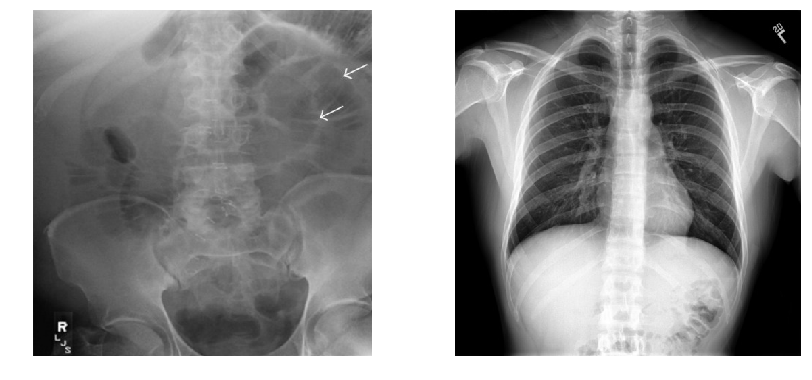

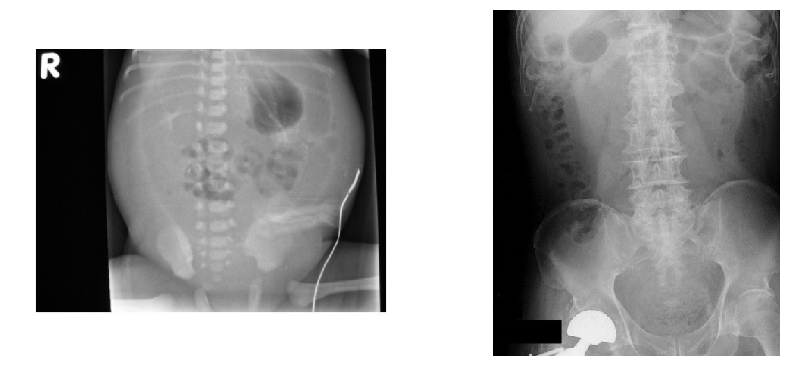

In [9]:
# visualize a few train images 
vis.display_images(train_image_ids[:2], cols=2)
vis.display_images(val_image_ids[:2], cols=2)

### Use Keras ML library for training and validation

In [10]:
from keras import applications
#from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [11]:
# Define model parameters 
img_width = 256
img_height = 256
epoch = 5

params = {'dim': (img_width,img_height),
          'batch_size': 5,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True, 
         }

In [12]:
# Transfer Learning 
# Use the InceptionV3 pre-trained model as base model 
base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
model_top  = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:], data_format=None)),  
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(2, activation='softmax')) 

model = Model(inputs=base_model.input, outputs=model_top(base_model.output))

model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import warnings
warnings.filterwarnings('ignore')

train_generator = utils.DataGenerator(train_dataset, **params)
val_generator = utils.DataGenerator(val_dataset, **params)

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', 
                             save_best_only=True)]

history = model.fit_generator(
            generator=train_generator,
            epochs=epoch,
            callbacks=callbacks,
            verbose=1,            
            validation_data=val_generator,
            use_multiprocessing=True, 
            workers=6)         

Epoch 1/5
13/13 [==============================] - 37s 3s/step - loss: 0.5301 - acc: 0.7231 - val_loss: 0.1175 - val_acc: 1.0000
Epoch 2/5
13/13 [==============================] - 28s 2s/step - loss: 0.1309 - acc: 0.9538 - val_loss: 0.0652 - val_acc: 1.0000
Epoch 3/5
13/13 [==============================] - 28s 2s/step - loss: 0.0467 - acc: 0.9846 - val_loss: 0.0129 - val_acc: 1.0000
Epoch 4/5
13/13 [==============================] - 28s 2s/step - loss: 0.0588 - acc: 0.9692 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 5/5
 1/13 [=>............................] - ETA: 23s - loss: 0.0031 - acc: 1.0000

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

### Create the Test dataset

In [ ]:
test_dataset = p.get_dataset_by_name('TEST')
test_dataset.prepare()

In [ ]:
from skimage.transform import resize

for image_id in test_dataset.image_ids: 
    
    image = vis.load_dicom_image(image_id, to_RGB=True)
    plt.figure()
    plt.imshow(image)
    
    image = resize(image, (img_width, img_height,3))
    x = np.expand_dims(image, axis=0)
    y_prob = model.predict(x) 
    y_classes = y_prob.argmax(axis=-1)
    title = 'Pred: ' + test_dataset.class_id_to_class_text(y_classes[0]) + ', prob:' + str(round(y_prob[0][y_classes[0]], 3))
    plt.title(title)
    
plt.show()